## Data collection, risk and return calculation

In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import yfinance as yf
from scipy.optimize import minimize
import cvxpy as cp

tickers = ['AAPL', 'MSFT', 'GOOGL', 'AMZN', 'META']
data = yf.download(tickers, start='2020-01-01', end='2024-06-01')['Adj Close']

# Calculate daily returns
returns = data.pct_change().dropna()

# Expected returns (mean of daily returns)
mean_returns = returns.mean()

# Covariance matrix of returns
cov_matrix = returns.cov()


[*********************100%%**********************]  5 of 5 completed


## Optimization function

In [15]:
def portfolio_performance(weights, mean_returns, cov_matrix, risk_free_rate=0.01):
    returns = np.dot(weights, mean_returns)
    std_dev = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights)))
    sharpe_ratio = (returns - risk_free_rate) / std_dev
    return std_dev, returns, sharpe_ratio

def neg_sharpe_ratio(weights, mean_returns, cov_matrix, risk_free_rate=0.01):
    return -portfolio_performance(weights, mean_returns, cov_matrix, risk_free_rate)[2]

def optimize_portfolio(mean_returns, cov_matrix, risk_free_rate=0.01, min_weight=0.05, max_weight=0.35):
    num_assets = len(mean_returns)
    args = (mean_returns, cov_matrix, risk_free_rate)

    # Adding weight constraints
    bounds = tuple((min_weight, max_weight) for _ in range(num_assets))
    constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})

    # Optimizing for maximum Sharpe ratio
    result = minimize(neg_sharpe_ratio, num_assets * [1. / num_assets,], args=args,
                      method='SLSQP', bounds=bounds, constraints=constraints)
    return result


## Running the optimization

In [18]:
optimal_portfolio = optimize_portfolio(mean_returns, cov_matrix)
optimal_weights = optimal_portfolio.x

std_dev, returns, sharpe_ratio = portfolio_performance(optimal_weights, mean_returns, cov_matrix)

print("Optimal Weights: ", optimal_weights)
print("Expected Return: ", returns)
print("Expected Volatility: ", std_dev)
print("Sharpe Ratio: ", sharpe_ratio)


Optimal Weights:  [0.05 0.35 0.2  0.35 0.05]
Expected Return:  0.0009002270482927366
Expected Volatility:  0.021686335241369918
Sharpe Ratio:  -0.41960860838986247


## Visualization

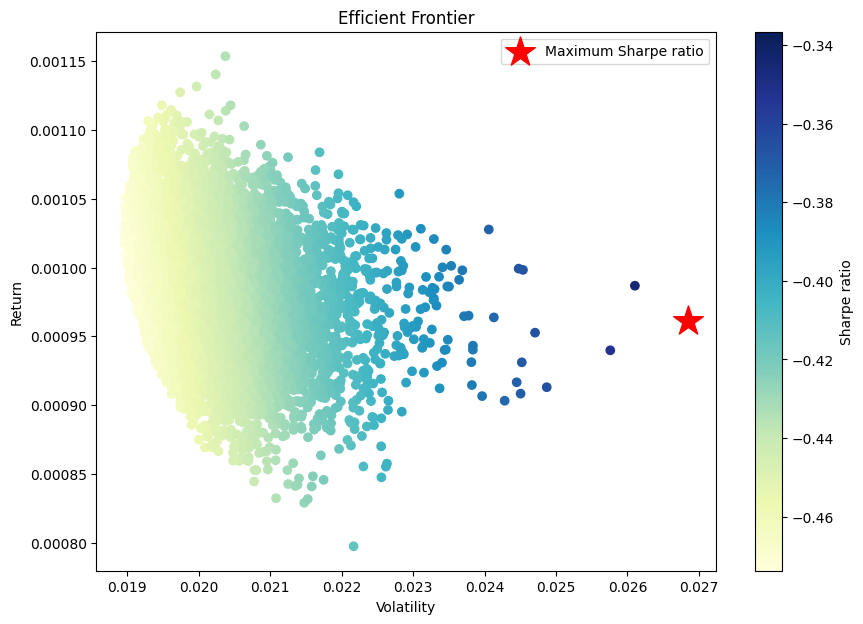

In [19]:
def plot_efficient_frontier(mean_returns, cov_matrix, num_portfolios=10000, risk_free_rate=0.01):
    results = np.zeros((3, num_portfolios))
    weights_record = []
    num_assets = len(mean_returns)

    for i in range(num_portfolios):
        weights = np.random.random(num_assets)
        weights /= np.sum(weights)
        weights_record.append(weights)
        portfolio_std_dev, portfolio_return, _ = portfolio_performance(weights, mean_returns, cov_matrix, risk_free_rate)
        results[0,i] = portfolio_std_dev
        results[1,i] = portfolio_return
        results[2,i] = (portfolio_return - risk_free_rate) / portfolio_std_dev

    max_sharpe_idx = np.argmax(results[2])
    sdp, rp = results[0, max_sharpe_idx], results[1, max_sharpe_idx]
    max_sharpe_allocation = weights_record[max_sharpe_idx]

    plt.figure(figsize=(10, 7))
    plt.scatter(results[0,:], results[1,:], c=results[2,:], cmap='YlGnBu', marker='o')
    plt.colorbar(label='Sharpe ratio')
    plt.scatter(sdp, rp, marker='*', color='r', s=500, label='Maximum Sharpe ratio')
    plt.title('Efficient Frontier')
    plt.xlabel('Volatility')
    plt.ylabel('Return')
    plt.legend(labelspacing=0.8)
    plt.show()

plot_efficient_frontier(mean_returns, cov_matrix)
